# DATAIKU TEST ALEXANDRE MONLOUIS

# Introduction 


The dataset contains about 300 000 rows and contains data about individuals , education work, family , race etc from the US Census bureau.
The goal is to predict whether an individual earns more than 50K dollars a year or not, and to give clear insights about the profiles of high income earners and visualise the data.
The dataset has about 6% individuals who earn more than 50K, thus making the dataset very unbalanced.
This project shows how to classify data with numerical and categorical data, on an unbalanced dataset ( 6 % of positives).
An important aspect is to have a good recall, as identifying most of the individuals with more than 50k earnings is important, but also a good precision, because we do not want to have too many false positives.
Thus, the ROC curves and setting threshold values for the classifier is an important aspect of the problem, and we will choose the f1 score as our performance metric.

The choice of the classifier will be logistic regression, a simple supervised algorithm. This model estimates probabilities which will be helpful to set thresholds. The data does not need to be normalised as the model is linear.

We do a 3 fold cross validation to see the performance of our model.However we are choosing the f1 score as the metric because we have an unabalanced dataset with few positive observations.

The plots of correlation and scatterplots are used to choose which variables we will be keeping, and variables whith a high amount of NUlls are discarded. Categorical variables are transformed into dummy variables in order to be used by the model.

We choose the parameters for our model using GridSearchCV, from scikit learn.


We import the needed python modules 

In [16]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from pandas.plotting import scatter_matrix
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score

Here we will start naming the columns according to the metadata file, and having a quick look at our data.

In [17]:
df= pd.read_csv('census_income_learn.csv')
df_test=pd.read_csv('census_income_test.csv')

columns=['AAGE','ACLSWKR','ADTIND','ADTOCC','AHGA','AHRSPAY','AHSCOL','AMARITL','AMJIND','AMJOCC','ARACE','AREORGN','ASEX','AUNMEM','AUNTYPE','AWKSTAT','CAPGAIN','CAPLOSS','DIVVAL','FILESTAT','GRINREG','GRINST','HHDFMX','HHDREL','MARSUPWT','MIGMTR1','MIGMTR3','MIGMTR4','MIGSAME','MIGSUN','NOEMP','PARENT','PEFNTVTY','PEMNTVTY','PENATVTY','PRCITSHP','SEOTR','VETQVA','VETYN','WKSWORK','YEAR','INCOME']
df.columns=columns
df_test.columns=columns

numerical=['AAGE','AHRSPAY','CAPGAIN','CAPLOSS','DIVVAL','NOEMP','WKSWORK','INCOME']
categorical=['ACLSWKR','ADTIND','ADTOCC','AHGA','AHSCOL','AMARITL','AMJIND','AMJOCC','ARACE','AREORGN','ASEX','AUNMEM','AUNTYPE','AWKSTAT','FILESTAT','GRINREG','GRINST','HHDFMX','HHDREL','MIGMTR1','MIGMTR3','MIGMTR4','MIGSAME','MIGSUN','PARENT','PEFNTVTY','PEMNTVTY','PENATVTY','PRCITSHP','SEOTR','VETQVA','VETYN','YEAR','INCOME']
weights_train=df['MARSUPWT']
weights_test=df_test['MARSUPWT']

y_train=pd.get_dummies(df['INCOME'])
y_train.drop(columns=' - 50000.',inplace=True) #this column is now redundant
y_train=np.ravel(y_train)
df["INCOME"]=y_train

y_test=pd.get_dummies(df_test['INCOME'])
y_test.drop(columns=' - 50000.',inplace=True) #this column is now redundant
df_test["INCOME"]=y_test
y_test=np.ravel(y_test)

df.drop(columns=['MARSUPWT'],inplace=True)
df_test.drop(columns=['INCOME','MARSUPWT'],inplace=True)

df[categorical]=df[categorical].astype(object)
df_test[categorical]=df[categorical].astype(object)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199522 entries, 0 to 199521
Data columns (total 41 columns):
AAGE        199522 non-null int64
ACLSWKR     199522 non-null object
ADTIND      199522 non-null object
ADTOCC      199522 non-null object
AHGA        199522 non-null object
AHRSPAY     199522 non-null int64
AHSCOL      199522 non-null object
AMARITL     199522 non-null object
AMJIND      199522 non-null object
AMJOCC      199522 non-null object
ARACE       199522 non-null object
AREORGN     199522 non-null object
ASEX        199522 non-null object
AUNMEM      199522 non-null object
AUNTYPE     199522 non-null object
AWKSTAT     199522 non-null object
CAPGAIN     199522 non-null int64
CAPLOSS     199522 non-null int64
DIVVAL      199522 non-null int64
FILESTAT    199522 non-null object
GRINREG     199522 non-null object
GRINST      199522 non-null object
HHDFMX      199522 non-null object
HHDREL      199522 non-null object
MIGMTR1     199522 non-null object
MIGMTR3     199522 

In [18]:
df.head()

,AAGE,ACLSWKR,ADTIND,ADTOCC,AHGA,AHRSPAY,AHSCOL,AMARITL,AMJIND,AMJOCC,...,PEFNTVTY,PEMNTVTY,PENATVTY,PRCITSHP,SEOTR,VETQVA,VETYN,WKSWORK,YEAR,INCOME
0,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,0
1,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,0
2,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,0
3,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,0
4,48,Private,40,10,Some college but no degree,1200,Not in universe,Married-civilian spouse present,Entertainment,Professional specialty,...,Philippines,United-States,United-States,Native- Born in the United States,2,Not in universe,2,52,95,0


We can see that we have both numerical data and categorical data.

We have a look at the distribution of our data for each variable, for the numerical data:

INCOME
0    [[AxesSubplot(0.125,0.670278;0.215278x0.209722...
1    [[AxesSubplot(0.125,0.670278;0.215278x0.209722...
dtype: object

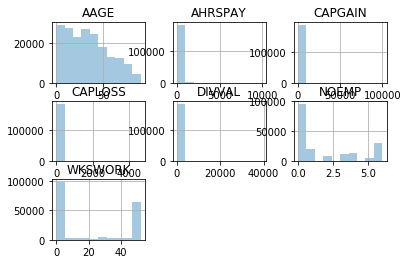

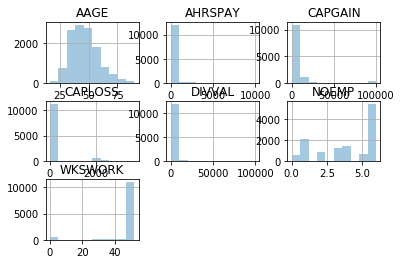

In [19]:

df[numerical].groupby('INCOME').hist(alpha=0.4) #_plot of the histograms of the numerical variable


We can already see that most values for capital and hourly wage are set to zero, and that high income earners are apparently more old than lower income earners.
We will now plot a scatter matrix to see relationships between our numerical variables.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001AE8798B940>,
      dtype=object)

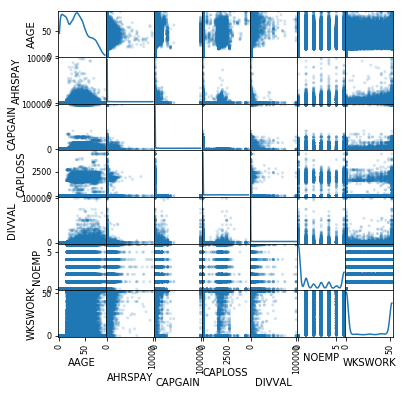

In [20]:

scatter_matrix(df[numerical], alpha=0.2, figsize=(6, 6), diagonal='kde')

We can see that hourly pay is not very reported in younger and older groups, and that higher pays are  more rare.

In [21]:
df.corr()

,AAGE,AHRSPAY,CAPGAIN,CAPLOSS,DIVVAL,NOEMP,WKSWORK
AAGE,1.000000,0.036940,0.053592,0.063353,0.104978,0.140895,0.206191
AHRSPAY,0.036940,1.000000,-0.001082,0.010993,-0.005731,0.191542,0.195687
CAPGAIN,0.053592,-0.001082,1.000000,-0.012700,0.131476,0.058015,0.083549
CAPLOSS,0.063353,0.010993,-0.012700,1.000000,0.042427,0.084255,0.100761
DIVVAL,0.104978,-0.005731,0.131476,0.042427,1.000000,0.007206,0.013823
NOEMP,0.140895,0.191542,0.058015,0.084255,0.007206,1.000000,0.747301
WKSWORK,0.206191,0.195687,0.083549,0.100761,0.013823,0.747301,1.000000


We can see that the number of employers is very correlated with the income.

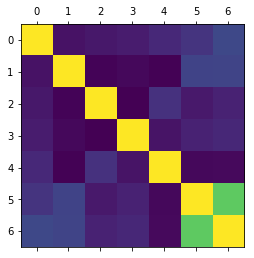

In [22]:
plt.matshow(df.corr())

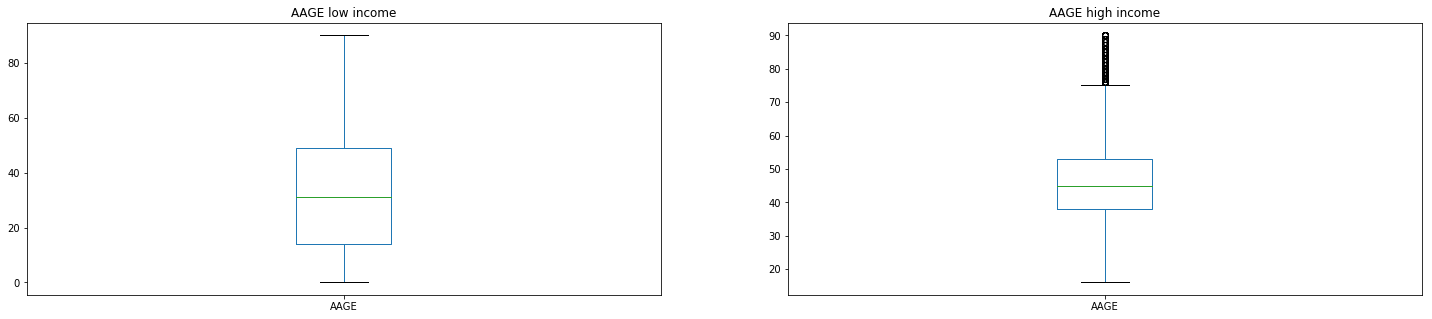

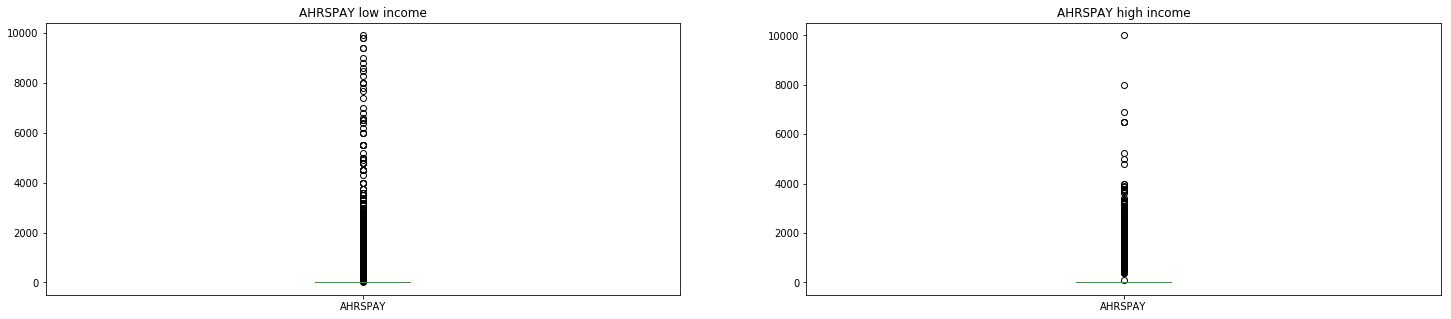

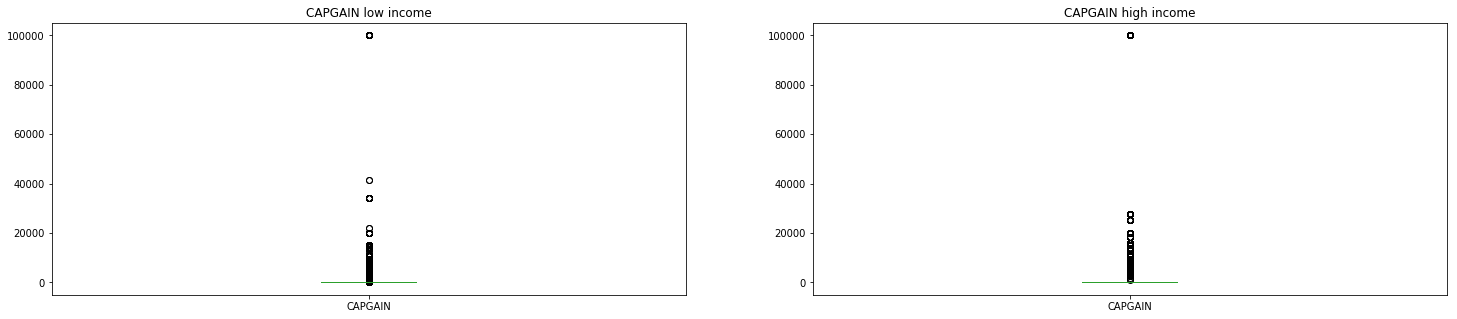

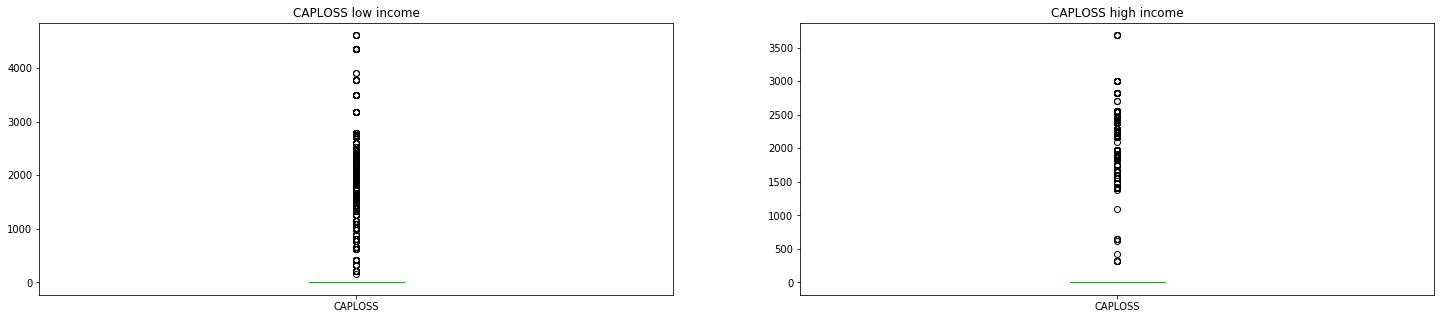

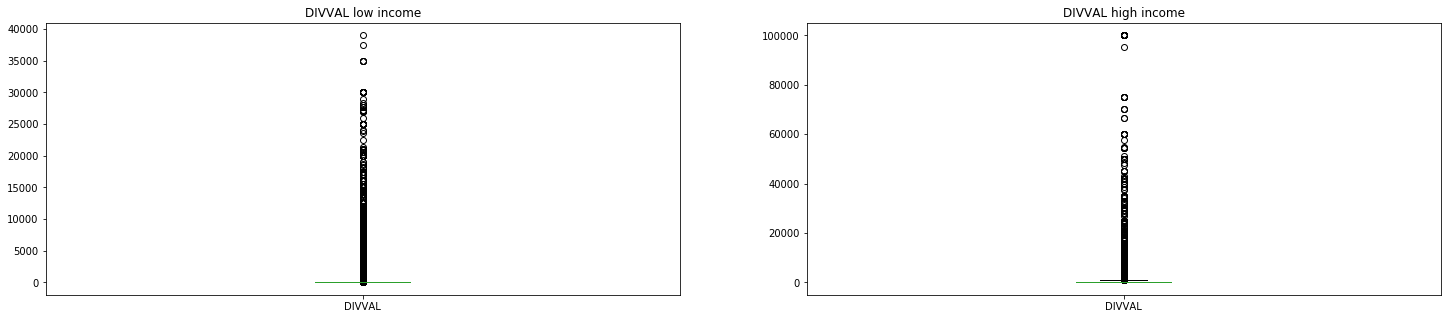

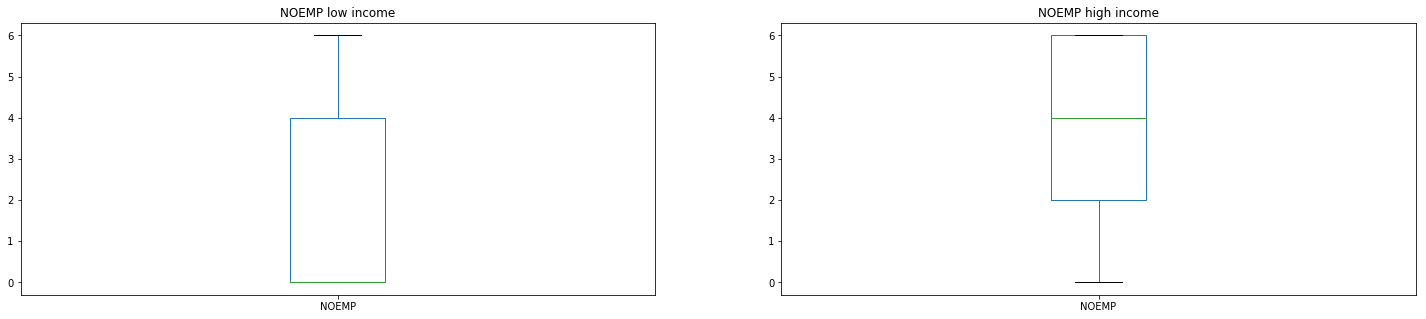

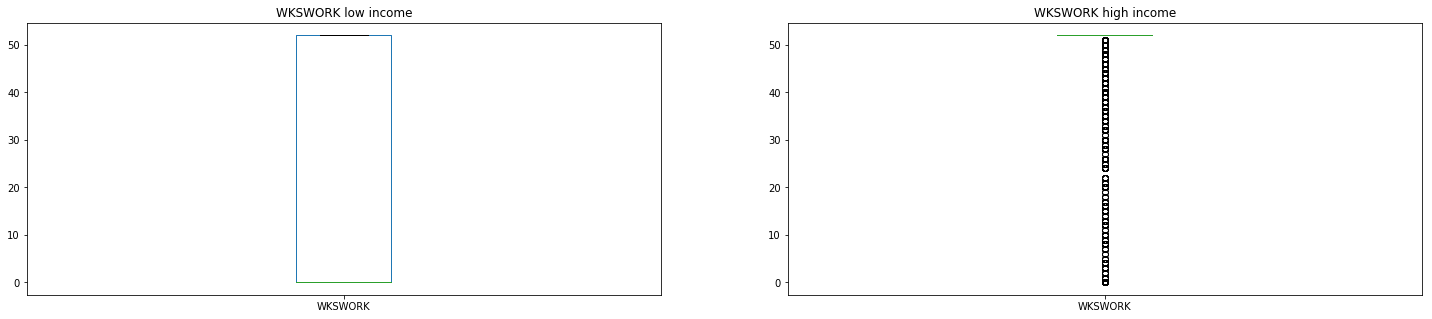

In [23]:
for k in numerical[:-1]:
    fig,axes=plt.subplots(nrows=1,ncols=2)
    df[k].loc[(df["INCOME"]==1) ].plot(kind="box",title=(k+' high income'),ax=axes[1],figsize=(25,5))
    df[k].loc[(df["INCOME"]==0) ].plot(kind="box",title=(k+' low income'),ax=axes[0],figsize=(25,5))
    plt.show()

These boxplots of the numerical data show that the median age of low income earners is 30 years old, compared to 45 years old for the higher income earners. This is logic because they had time to finish their studies and start earning money. Capital income and dividends are often not present/reported throughout the dataset, because most people earn money through their wage only.Finally, compared to low incomes, high income earners typically work more than 50 weeks a year, and have worked for several employers (2-6) before.

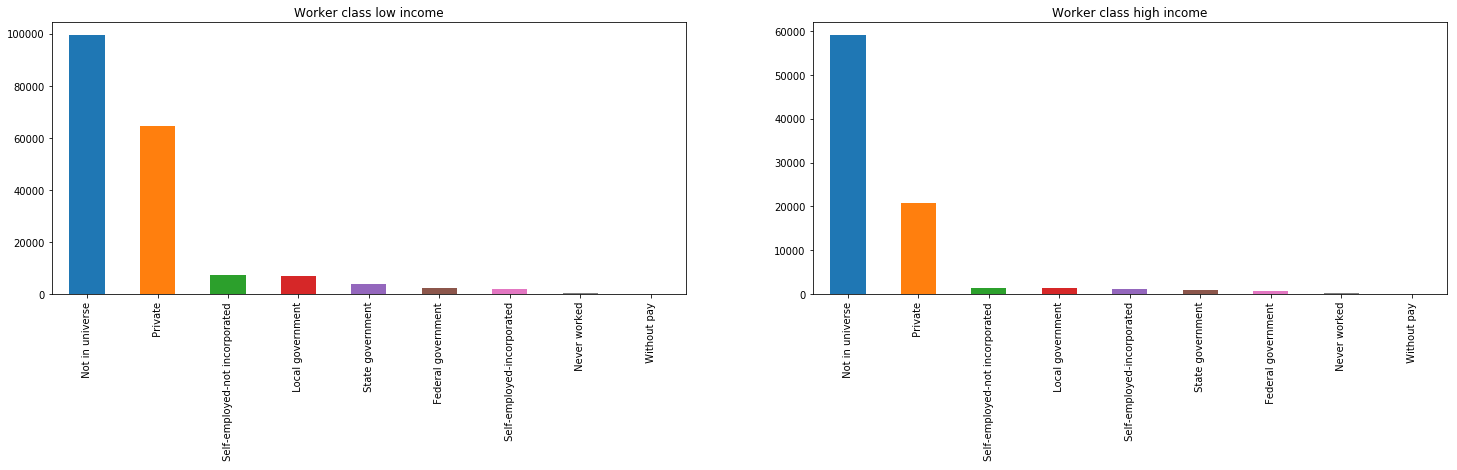

In [24]:
fig,axes=plt.subplots(nrows=1,ncols=2)
df['ACLSWKR'].loc[df["INCOME"]==1 & (df["AAGE"]>=25)].value_counts().plot(kind="bar",title=('Worker class'+' high income'),ax=axes[1],figsize=(25,5))
df['ACLSWKR'].loc[df["INCOME"]==0 & (df["AAGE"]>=25)].value_counts().plot(kind="bar",title=('Worker class'+' low income'),ax=axes[0],figsize=(25,5))
plt.show()

We can see that people with lower income are more likely to be unemployed (Not in universe)
We took age over 25 in order to remove children

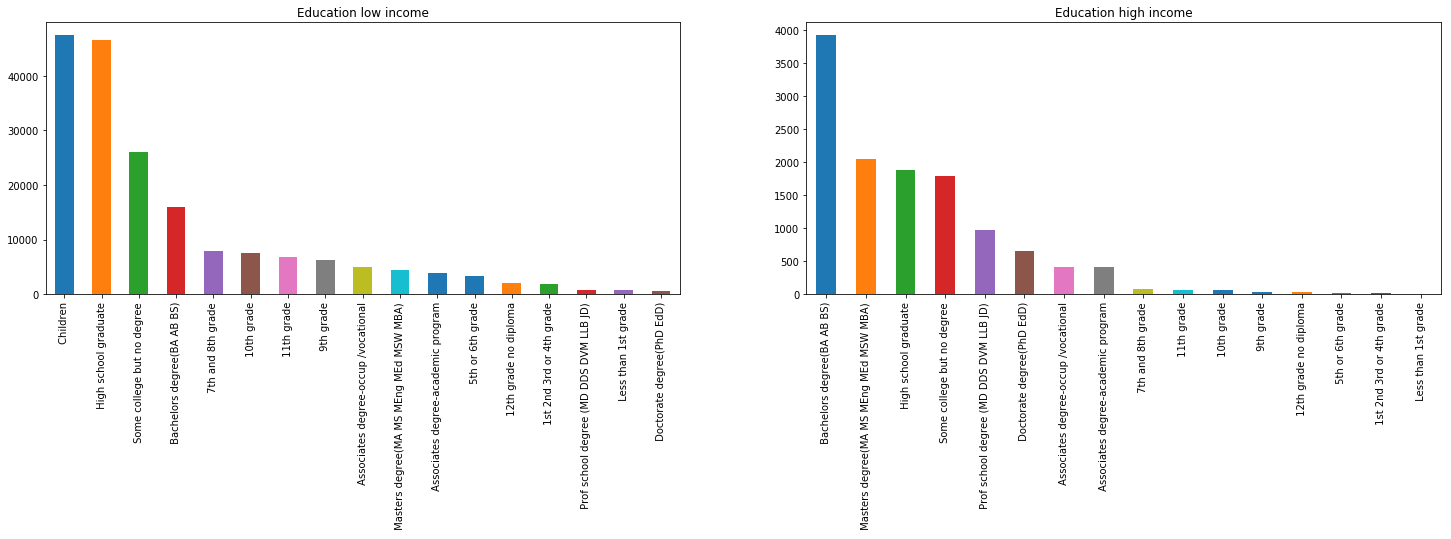

In [25]:
fig,axes=plt.subplots(nrows=1,ncols=2)
df['AHGA'].loc[df["INCOME"]==1].value_counts().plot(kind="bar",title=('Education'+' high income'),ax=axes[1],figsize=(25,5))
df['AHGA'].loc[df["INCOME"]==0].value_counts().plot(kind="bar",title=('Education'+' low income'),ax=axes[0],figsize=(25,5))
plt.show()

As expected, higher income earners typically went further in their studies

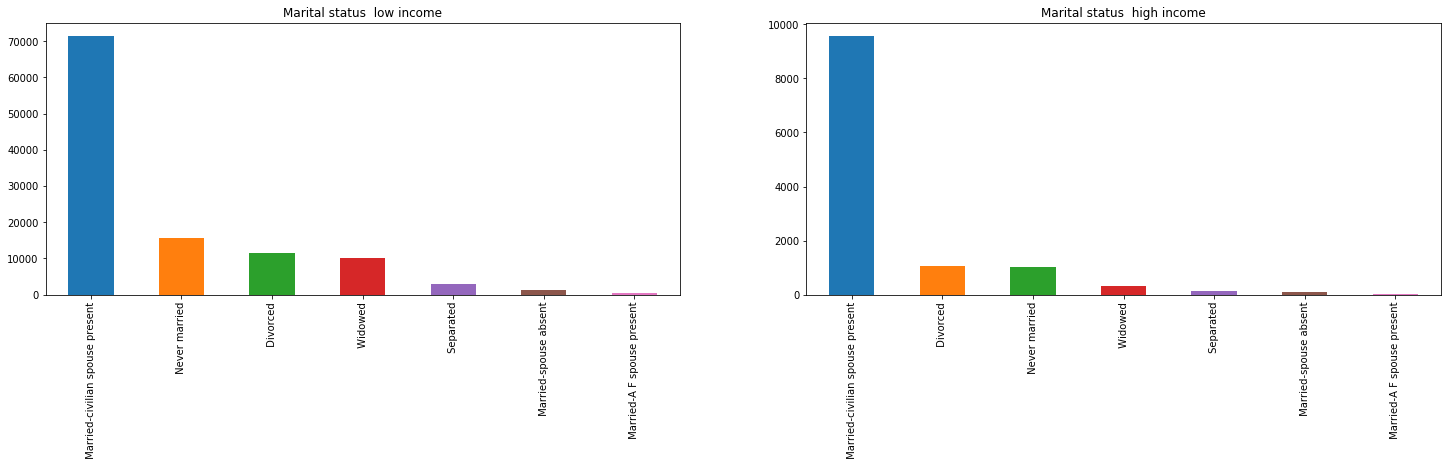

In [26]:
fig,axes=plt.subplots(nrows=1,ncols=2)
df['AMARITL'].loc[(df["INCOME"]==1) & (df["AAGE"]>=25)].value_counts().plot(kind="bar",title=('Marital status '+' high income'),ax=axes[1],figsize=(25,5))
df['AMARITL'].loc[(df["INCOME"]==0) & (df["AAGE"]>=25)].value_counts().plot(kind="bar",title=('Marital status '+' low income'),ax=axes[0],figsize=(25,5))
plt.show()

This plot shows that wealthy adults are more likely to be married than lower income adults.

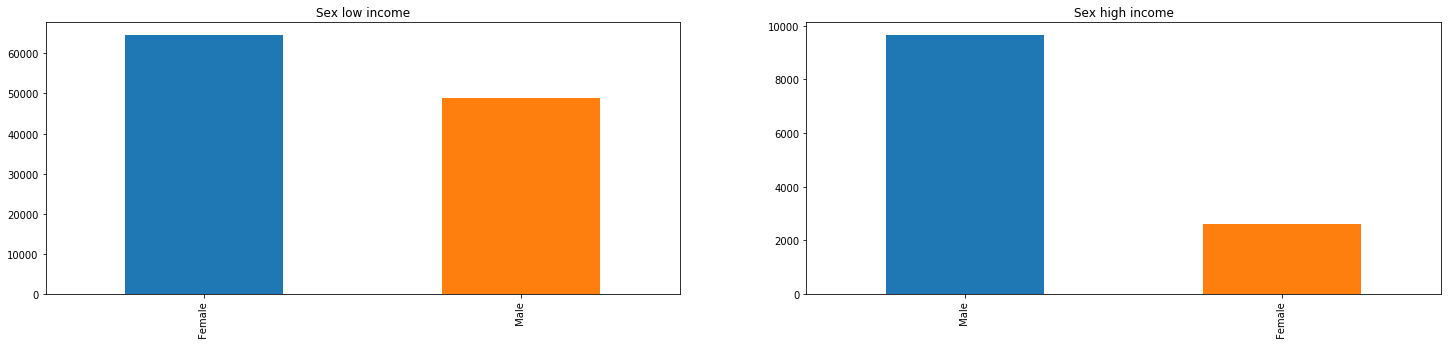

In [27]:
fig,axes=plt.subplots(nrows=1,ncols=2)
df['ASEX'].loc[(df["INCOME"]==1) & (df["AAGE"]>=25)].value_counts().plot(kind="bar",title=('Sex'+' high income'),ax=axes[1],figsize=(25,5))
df['ASEX'].loc[(df["INCOME"]==0) & (df["AAGE"]>=25)].value_counts().plot(kind="bar",title=('Sex'+' low income'),ax=axes[0],figsize=(25,5))
plt.show()

Women have a harder time than men earning more than 50k a year. 

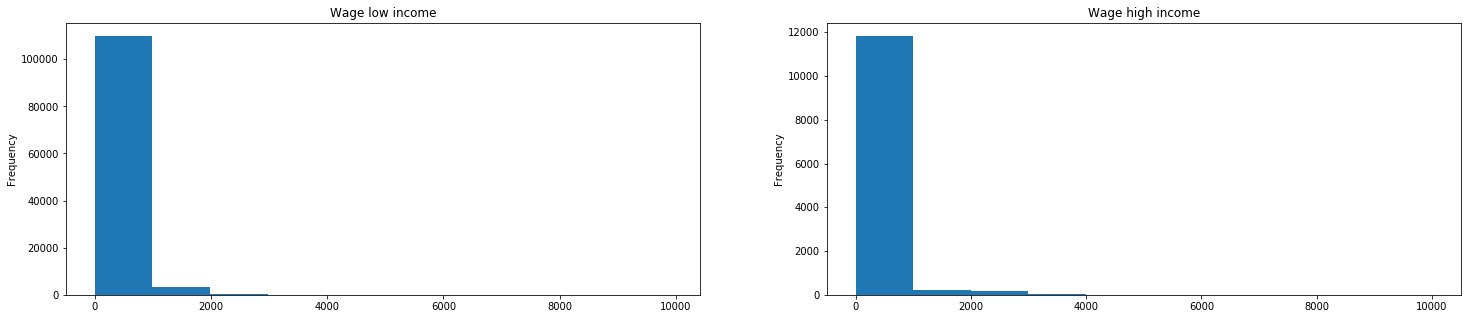

In [28]:
fig,axes=plt.subplots(nrows=1,ncols=2)
df['AHRSPAY'].loc[(df["INCOME"]==1) & (df["AAGE"]>=25)].plot(kind="hist",title=('Wage'+' high income'),ax=axes[1],figsize=(25,5))
df['AHRSPAY'].loc[(df["INCOME"]==0) & (df["AAGE"]>=25)].plot(kind="hist",title=('Wage'+' low income'),ax=axes[0],figsize=(25,5))
plt.show()

In [29]:
df['AHRSPAY'].loc[ (df["AHRSPAY"]==0)].count()

188218

We see that wages tend to go in a higher range for the high income earners, however, the count shows that 188 218 survey respond stated their hourly wage was 0 , which shows this question is not answered very much, maybe for privacy reasons.

# Feature engineering

We will first create a column which represents the net capital,which comprises of the gains and losses.

In [30]:
df["CAPGAIN"]=df["CAPGAIN"]-df["CAPLOSS"]
df.drop(columns=["CAPLOSS"],inplace=True)
df["CAPGAIN"].rename("CAPNET")

df_test["CAPGAIN"]=df_test["CAPGAIN"]-df_test["CAPLOSS"]
df_test.drop(columns=["CAPLOSS"],inplace=True)
df_test["CAPGAIN"].rename("CAPNET")

numerical[2]="CAPNET"
numerical.remove("CAPLOSS")

We will drop the wage column, because very it has a very low correlation with income and most people chose not to report their wage .  
We will keep the industry and occapation recodes which are more precise than the major industry and major occupation codes.
We drop previous region and state because of the high rate of Not in universe and low correlations with labels.
We drop migration codes (missing values, unknown values and uncorrelated to labels).
Household summary in household is dropped  as it contains less information than detailed household and family stat.
Country of birth,country of birth father and mother are dropped,most values are USA,it is not useful data and will add many variables to the model. 
We drop citizenship ,low correlation, mostly and does not differentiate foreign countries.
Use to live in Sunbelt is dropped : most of the values are missing or unknown. 
eteran questionnaire is discarded as most values are not in universe. 
The year is dropped as it has no correlation with the income category (Pearson correlation 0.005)

In [31]:
correlation=x_train=pd.get_dummies(df.drop(columns=["AHRSPAY","AMJIND","AMJOCC","GRINREG","GRINST","HHDREL","MIGMTR1","MIGMTR3","MIGMTR4","MIGSUN","PEFNTVTY","PEMNTVTY","PENATVTY","PRCITSHP","VETQVA","YEAR"]),drop_first=True).corr()
correlation["INCOME_1"].loc[(correlation["INCOME_1"]>=0.2) | (correlation["INCOME_1"]<=-0.2)]

CAPGAIN                          0.231635
NOEMP                            0.222683
WKSWORK                          0.262316
ACLSWKR_ Not in universe        -0.220913
ADTOCC_2                         0.230988
FILESTAT_ Joint both under 65    0.205192
HHDFMX_ Householder              0.213482
INCOME_1                         1.000000
Name: INCOME_1, dtype: float64

The variables most correlated to wealthiness are the number of worked weeks in a year, occupation, capital gains, number of employers in the past. Also the fact that a person does not work is very discriminative and shows a high probability of earning a low income.

# Data modeling

In [32]:
concat=pd.concat([df,df_test])
concat.drop(columns=["AHRSPAY","AMJIND","AMJOCC","GRINREG","GRINST","HHDREL","MIGMTR1","MIGMTR3","MIGMTR4","MIGSUN","PEFNTVTY","PEMNTVTY","PENATVTY","PRCITSHP","VETQVA","YEAR","INCOME"],inplace=True)
dummies=pd.get_dummies(concat,drop_first=True)
x_train=dummies[:199522]
x_test=dummies[199522:]
x_train.info()
x_test.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199522 entries, 0 to 199521
Columns: 214 entries, AAGE to VETYN_2
dtypes: int64(5), uint8(209)
memory usage: 48.9 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 99761 entries, 0 to 99760
Columns: 214 entries, AAGE to VETYN_2
dtypes: int64(5), uint8(209)
memory usage: 24.5 MB


In [33]:
from sklearn import model_selection

param_grid = {
              'penalty': ['l1','l2'],
    'C':[0.5,1,2]
             }

lr_gs = model_selection.GridSearchCV(LogisticRegression(), param_grid,scoring='f1',cv=3)
lr_gs.fit(x_train, y_train)

print(lr_gs.best_params_)
lr_gs.cv_results_

{'C': 2, 'penalty': 'l1'}


c:\users\alexmonlou\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
c:\users\alexmonlou\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
c:\users\alexmonlou\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=Tru

{'mean_fit_time': array([53.6604294 ,  4.49396984, 29.25245571,  5.01626611, 25.9478697 ,
         5.48502501]),
 'mean_score_time': array([0.19381626, 0.18317819, 0.18182222, 0.18350919, 0.19880231,
        0.20079621]),
 'mean_test_score': array([0.49145809, 0.48923836, 0.4922147 , 0.49113087, 0.49294327,
        0.49252998]),
 'mean_train_score': array([0.49919149, 0.4970937 , 0.50076391, 0.49869984, 0.50089154,
        0.49940018]),
 'param_C': masked_array(data=[0.5, 0.5, 1, 1, 2, 2],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_penalty': masked_array(data=['l1', 'l2', 'l1', 'l2', 'l1', 'l2'],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.5, 'penalty': 'l1'},
  {'C': 0.5, 'penalty': 'l2'},
  {'C': 1, 'penalty': 'l1'},
  {'C': 1, 'penalty': 'l2'},
  {'C': 2, 'penalty': 'l1'},
  {'C': 2, 'penalty': 'l2'}],
 'rank_test_

The grid search enables to choose good parameters for our logistic regressor. We will choose the best parameters found in the future. We will now fit our model and make predictions using  L1 regression , lasso.
The advantage of Lasso is that it does feature selection, and discards variables with low influence on classification.

In [36]:
model_logistic=LogisticRegression(C=2,penalty='l1')
model_logistic.fit(x_train,y_train)
predictions_logistic=model_logistic.predict(x_test)

print(confusion_matrix(y_test,predictions_logistic))
print(classification_report(y_test, predictions_logistic))

[[92632   943]
 [ 5702   484]]
             precision    recall  f1-score   support

          0       0.94      0.99      0.97     93575
          1       0.34      0.08      0.13      6186

avg / total       0.90      0.93      0.91     99761



In [39]:

#best f1 score :
probas=model_logistic.predict_proba(x_test)[:,1]
threshbest,f1best=0,0
for i in range(100):
    print(f1best,threshbest)
    thresh=i/100
    true_pos = sum([(probas[k] > thresh) * (y_test[k] == 1) for k in range(len(probas))])
    false_pos = sum([(probas[k] > thresh) * (y_test[k] == 0) for k in range(len(probas))])
    false_neg = sum([(probas[k] <= thresh) * (y_test[k] == 1) for k in range(len(probas))])
    true_neg = sum([(probas[k] <= thresh) * (y_test[k] == 0) for k in range(len(probas))])

    recall = true_pos / (true_pos + false_neg)
    precision = true_pos / (true_pos + false_pos)
    f1 = 2 * precision * recall / (precision + recall)
    if f1>f1best:
        f1best=f1
        threshbest=thresh
print(f1best,threshbest)

0 0
0.11677536881648372 0.0
0.19250841967246832 0.01
0.20525940799274567 0.02
0.2139267767408471 0.03
0.21860068259385665 0.04
0.221006461349809 0.05
0.2223811957077159 0.06
0.2223811957077159 0.06
0.2223811957077159 0.06
0.2224825800086329 0.09
0.2224825800086329 0.09
0.2224825800086329 0.09
0.2224825800086329 0.09
0.2224825800086329 0.09
0.2224825800086329 0.09
0.2224825800086329 0.09
0.2224825800086329 0.09
0.2224825800086329 0.09
0.2224825800086329 0.09
0.2224825800086329 0.09
0.2224825800086329 0.09
0.2224825800086329 0.09
0.2224825800086329 0.09
0.2224825800086329 0.09
0.2224825800086329 0.09
0.2224825800086329 0.09
0.2224825800086329 0.09
0.2224825800086329 0.09
0.2224825800086329 0.09
0.2224825800086329 0.09
0.2224825800086329 0.09
0.2224825800086329 0.09
0.2224825800086329 0.09
0.2224825800086329 0.09
0.2224825800086329 0.09
0.2224825800086329 0.09
0.2224825800086329 0.09
0.2224825800086329 0.09
0.2224825800086329 0.09
0.2224825800086329 0.09
0.2224825800086329 0.09
0.22248258

0.7018100959489074

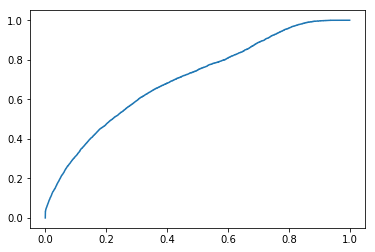

In [41]:
fpr,tpr,thresholds=roc_curve(y_test,model_logistic.predict_proba(x_test)[:,1]) #roc_auc_score curves
plt.plot(fpr,tpr,label="ROC Curve")
# roc curve
roc_auc_score(y_test,model_logistic.predict_proba(x_test)[:,1])


After setting the threshold, we have a  maximum 0.22 f1 score on the test set, with a 0.09 threshold.The ROC score is 0.70, which means the probabilty of correctly classifying a positive-negative pair is 0.7.


# Conclusion 

Our analysis shows that the variables most correlated to wealthiness are the number of worked weeks in a year, occupation, capital gains, number of employers in the past. Also the fact that a person does not work is very discriminative and shows a high probability of earning a low income. The difficult part about this task was to choose which variables to keep , and which to discard . We brought clear insights to profiles of people who earn more than 50k in income

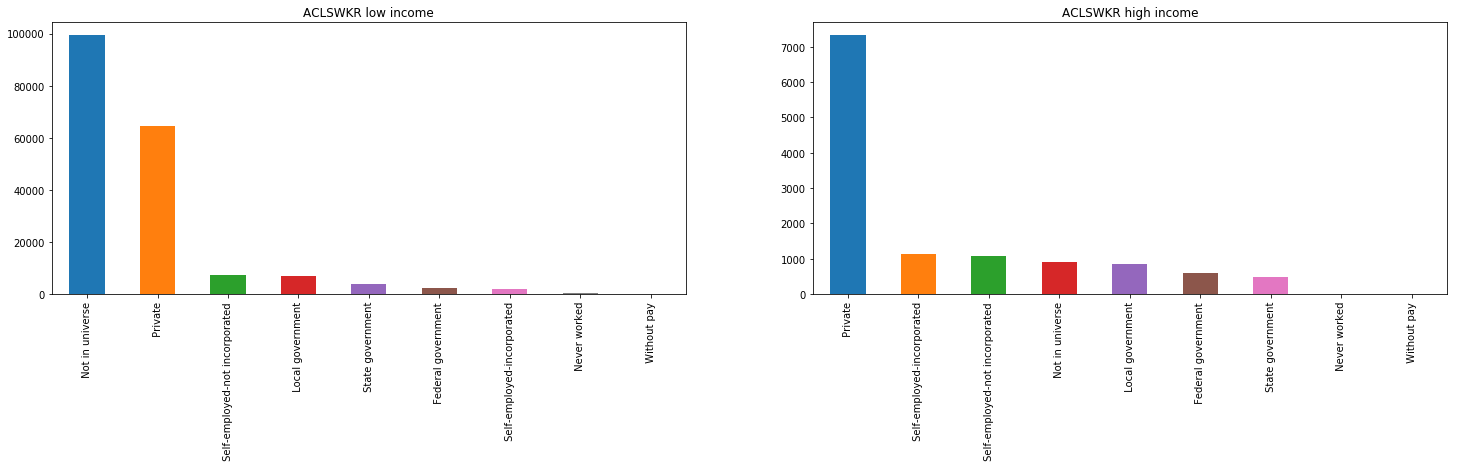

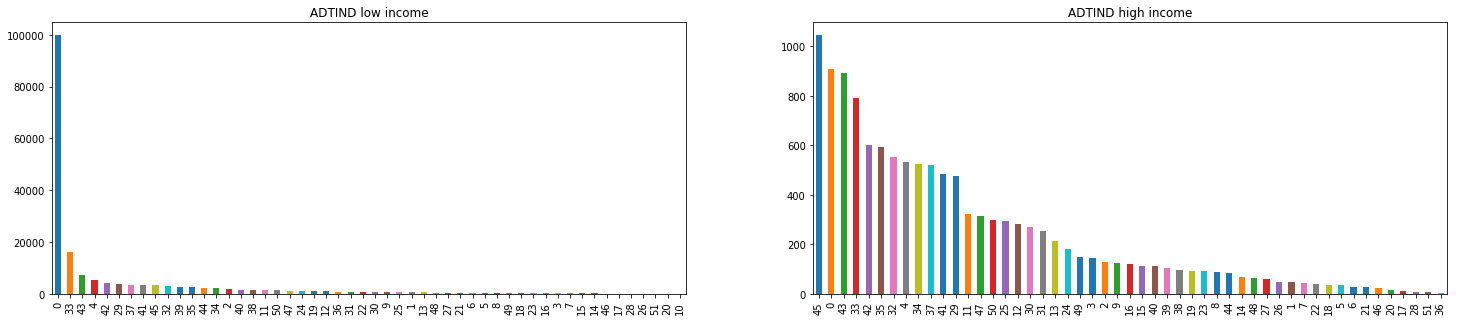

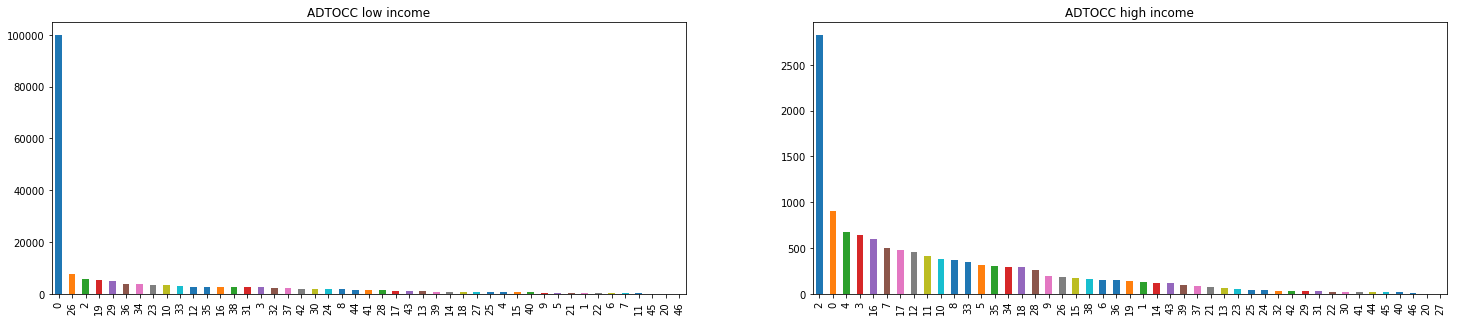

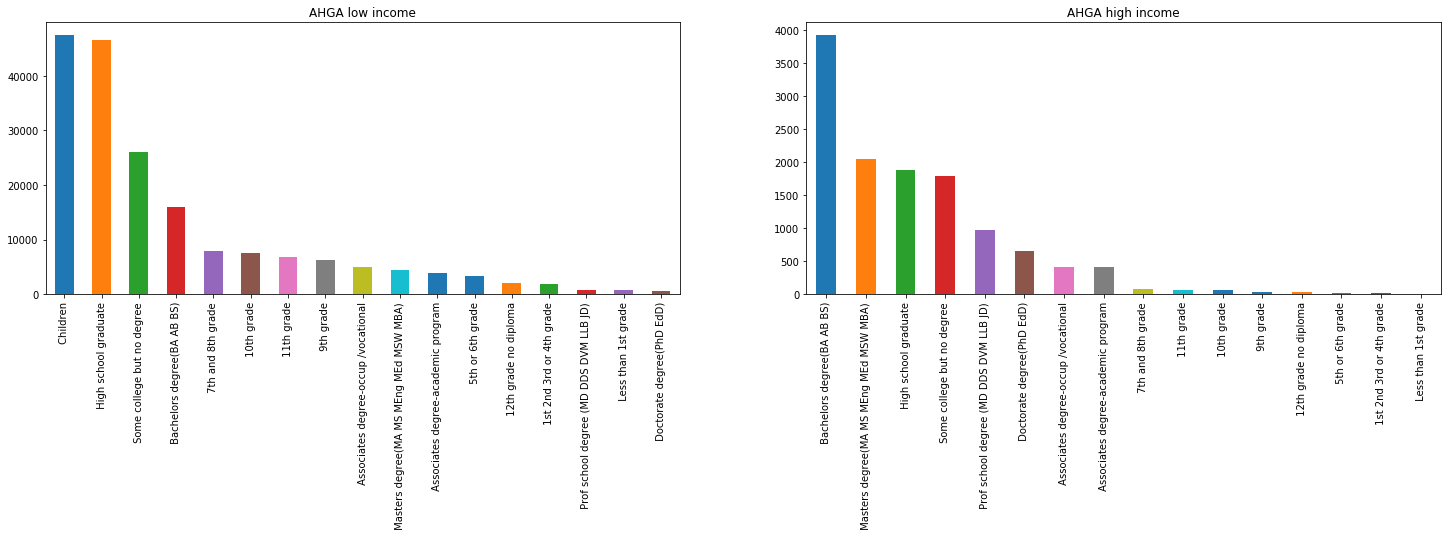

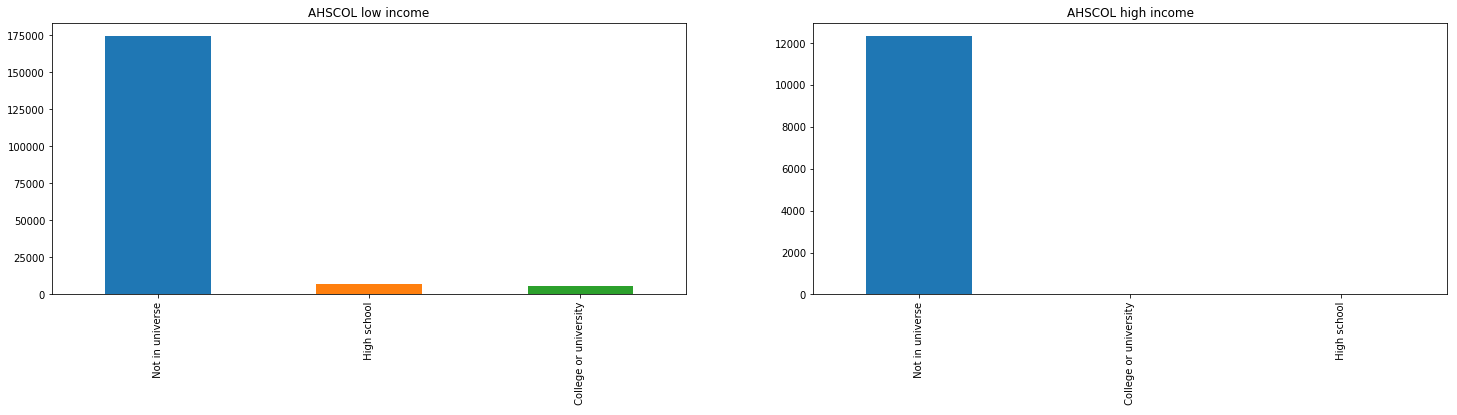

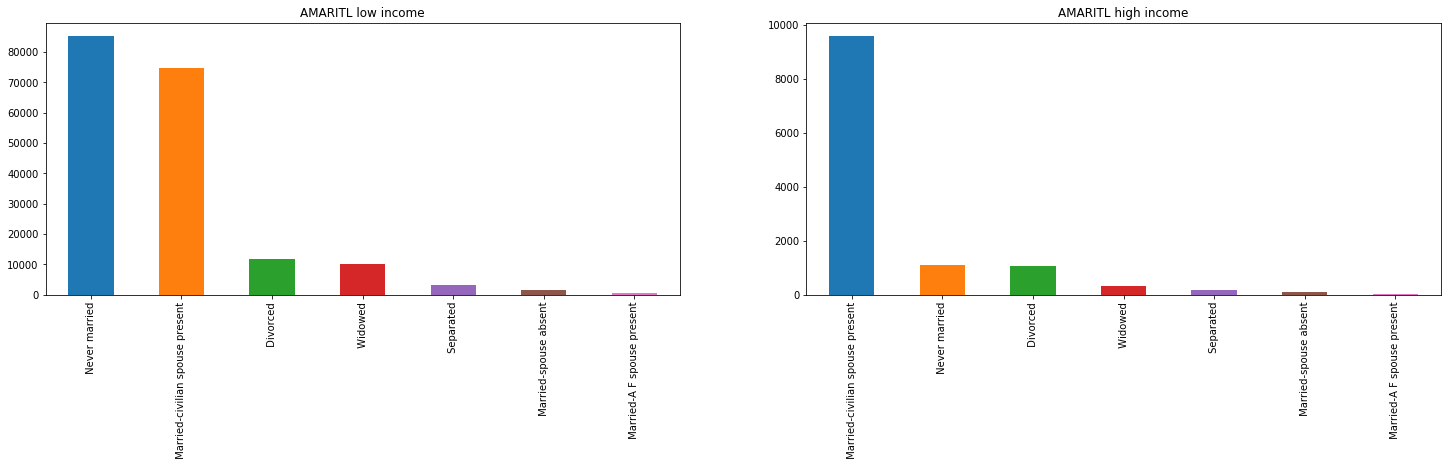

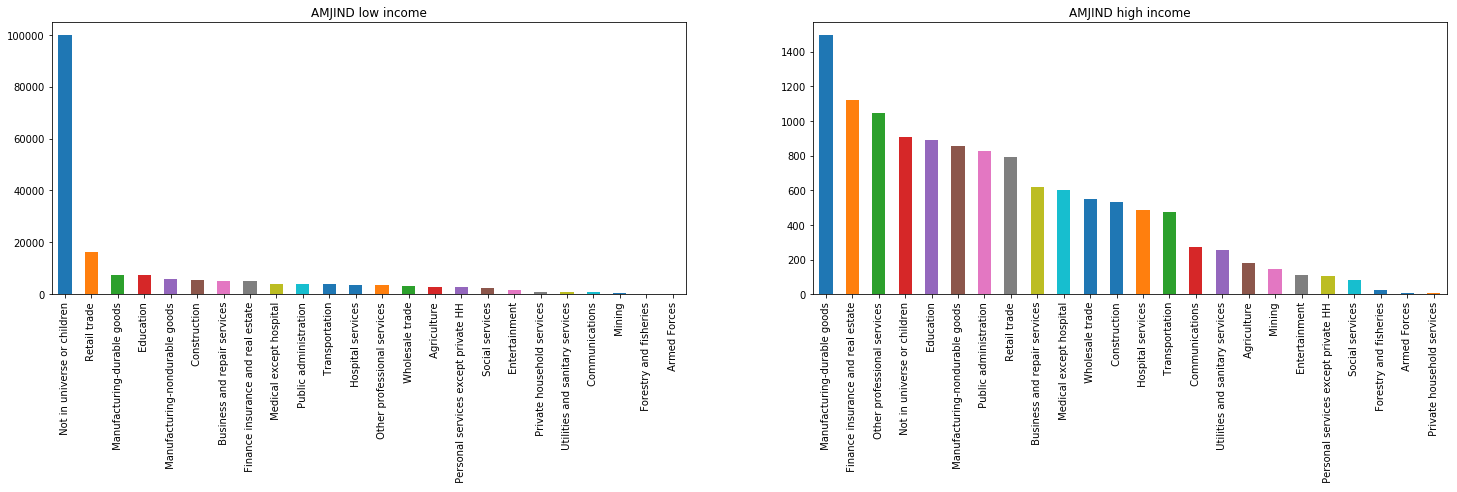

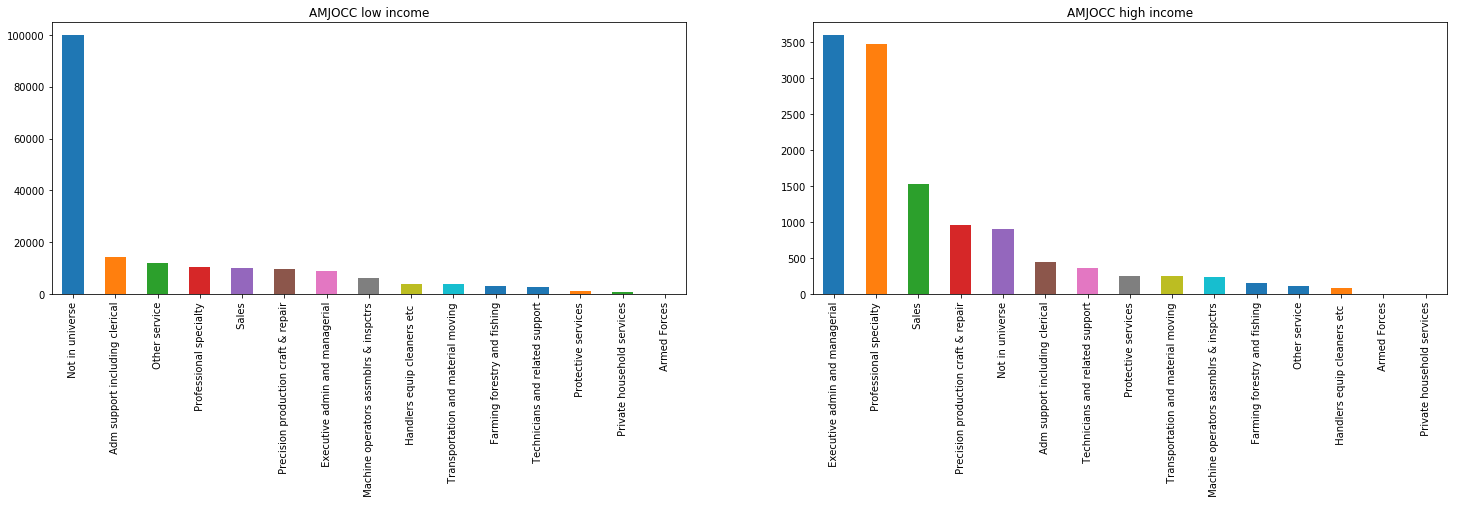

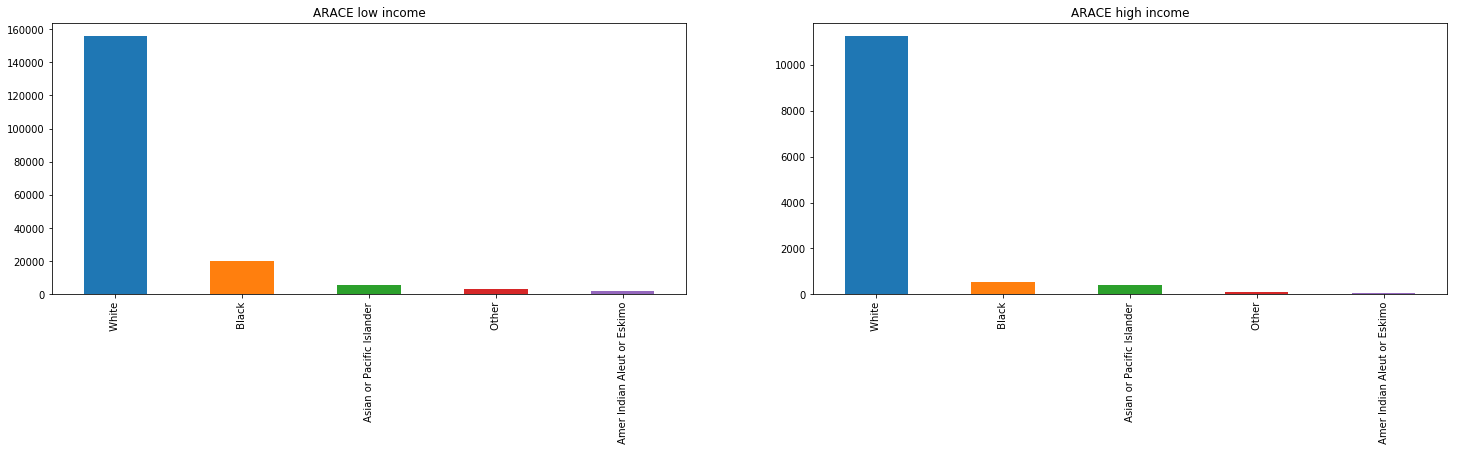

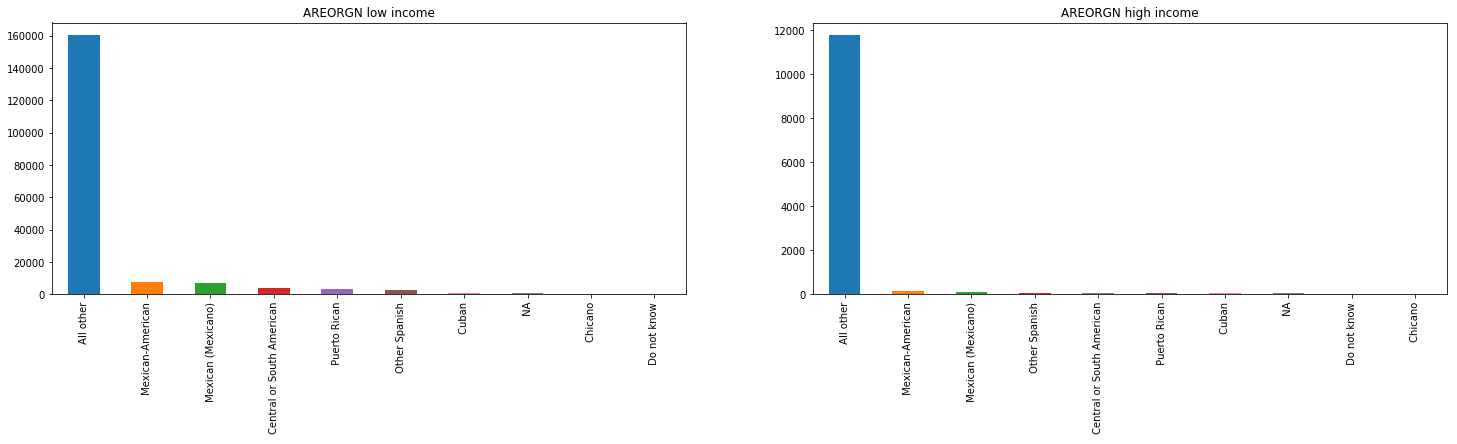

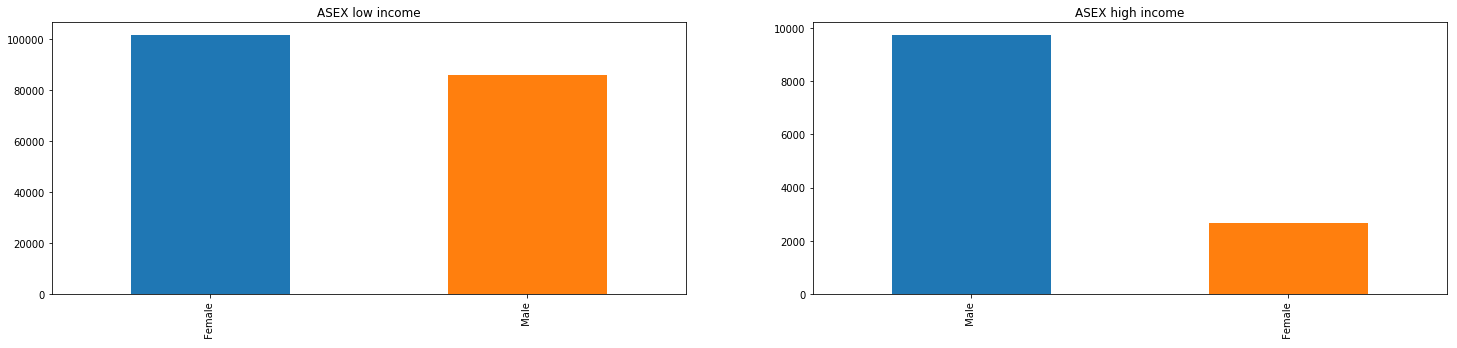

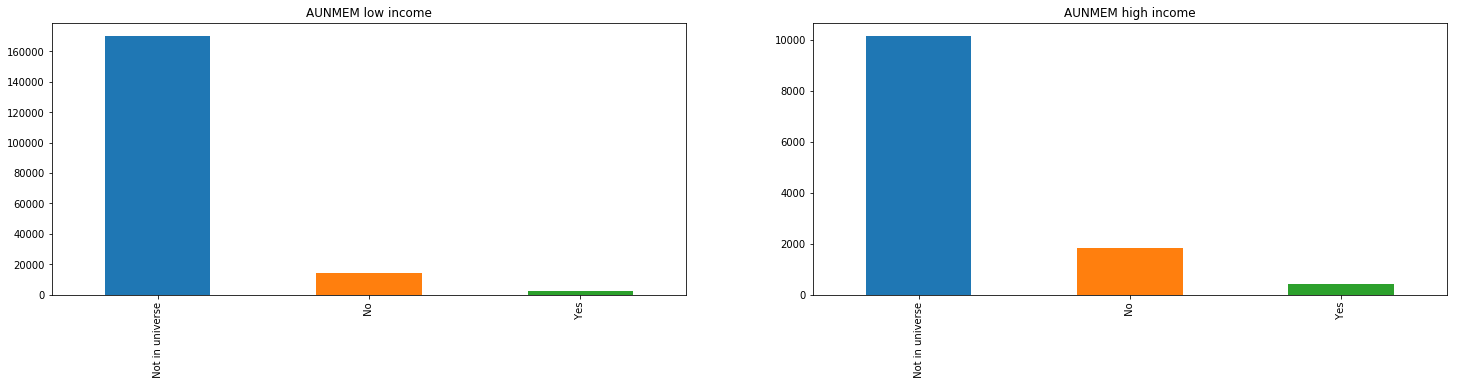

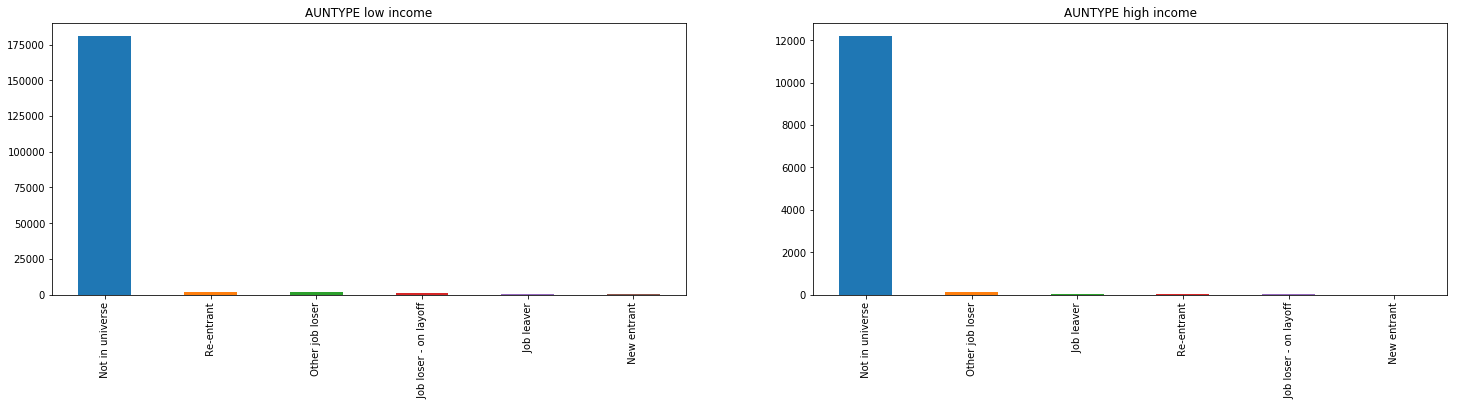

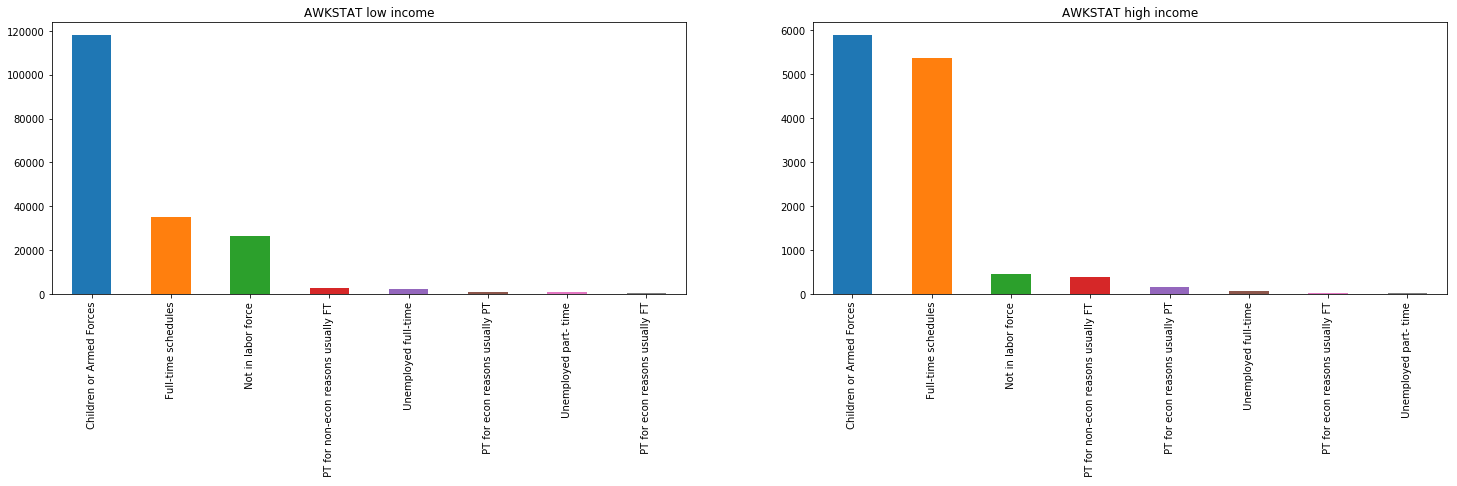

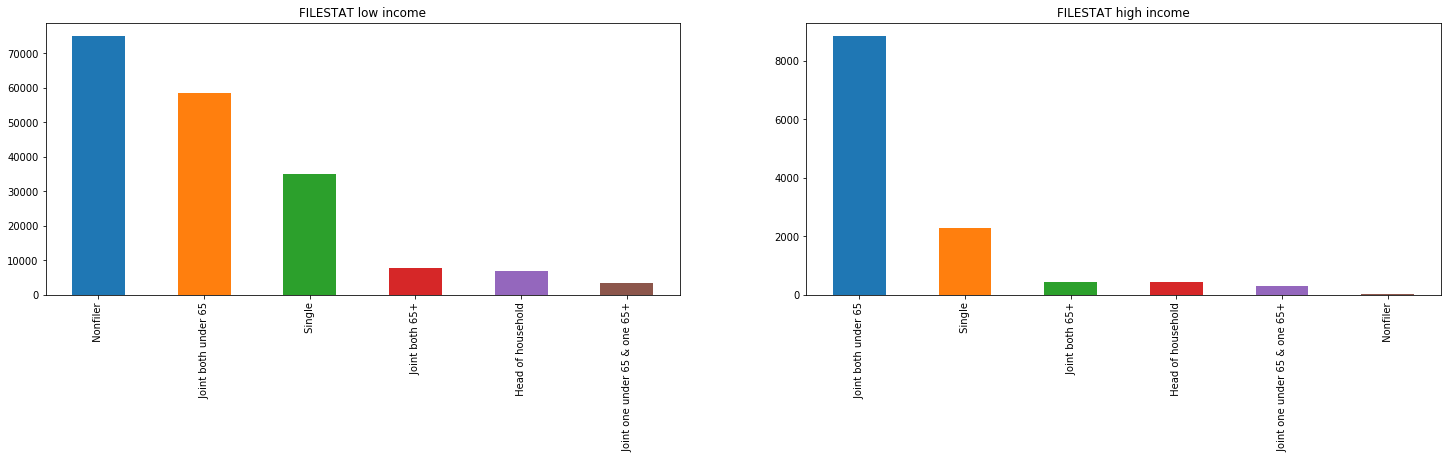

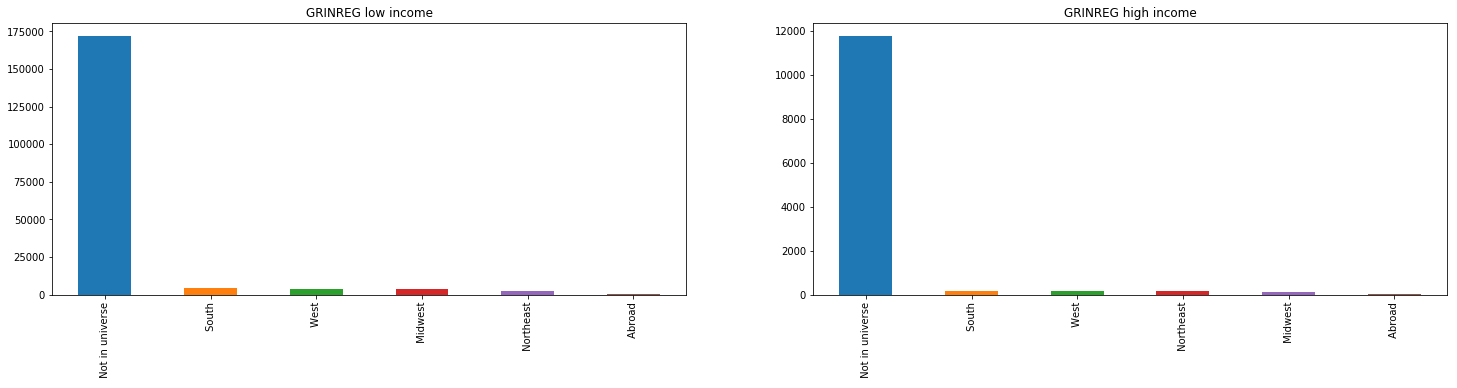

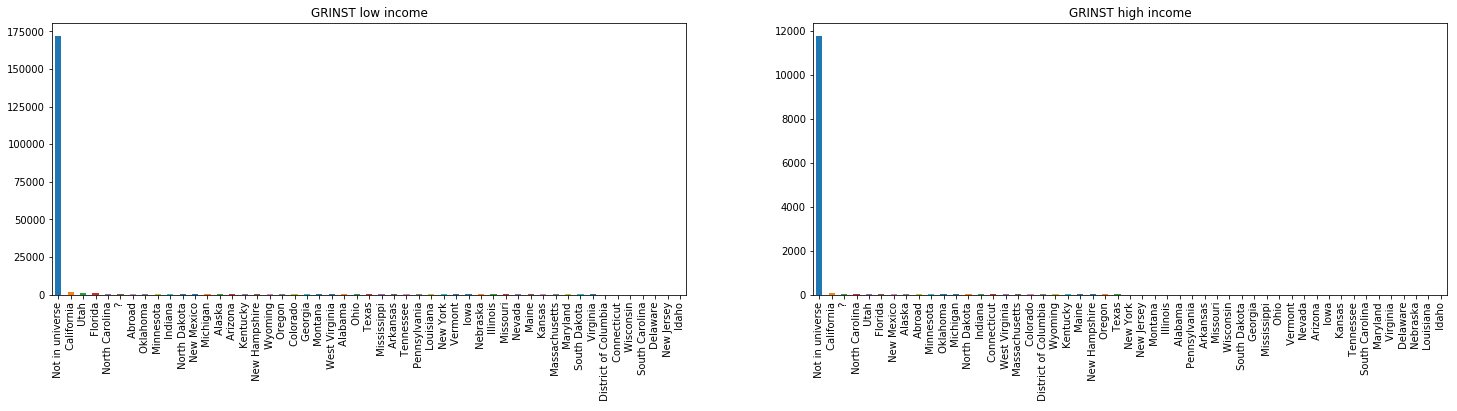

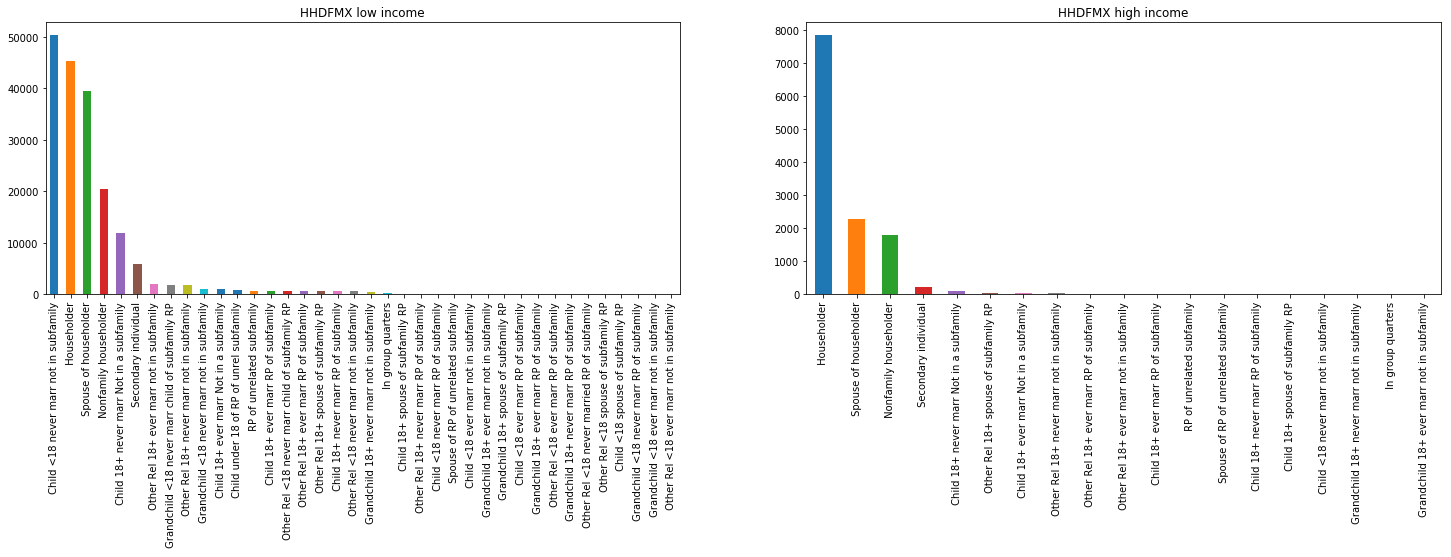

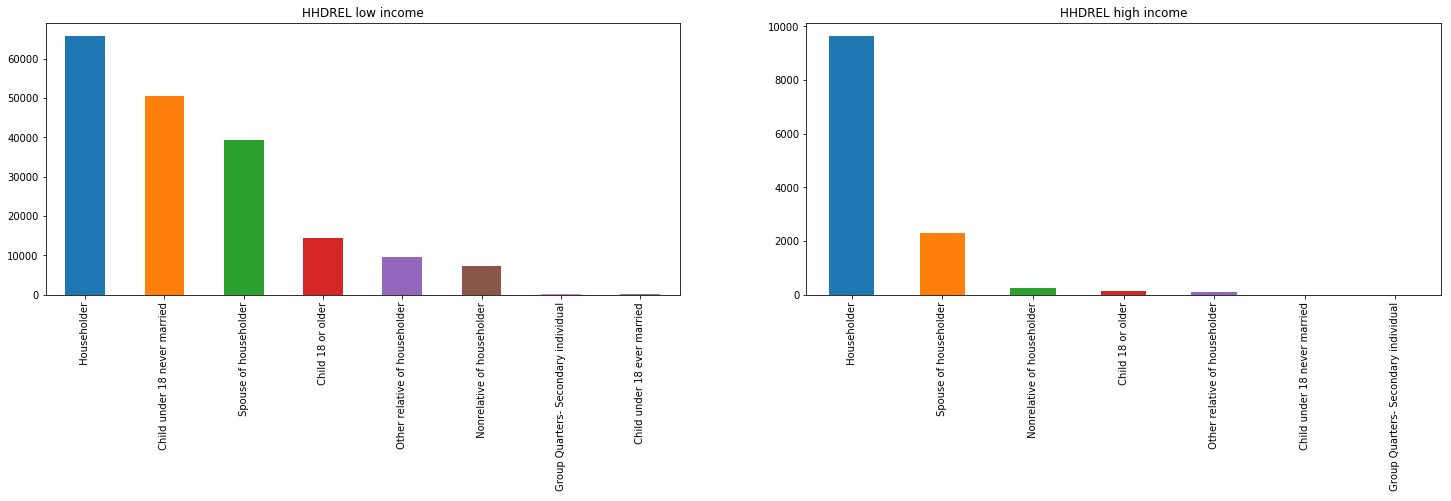

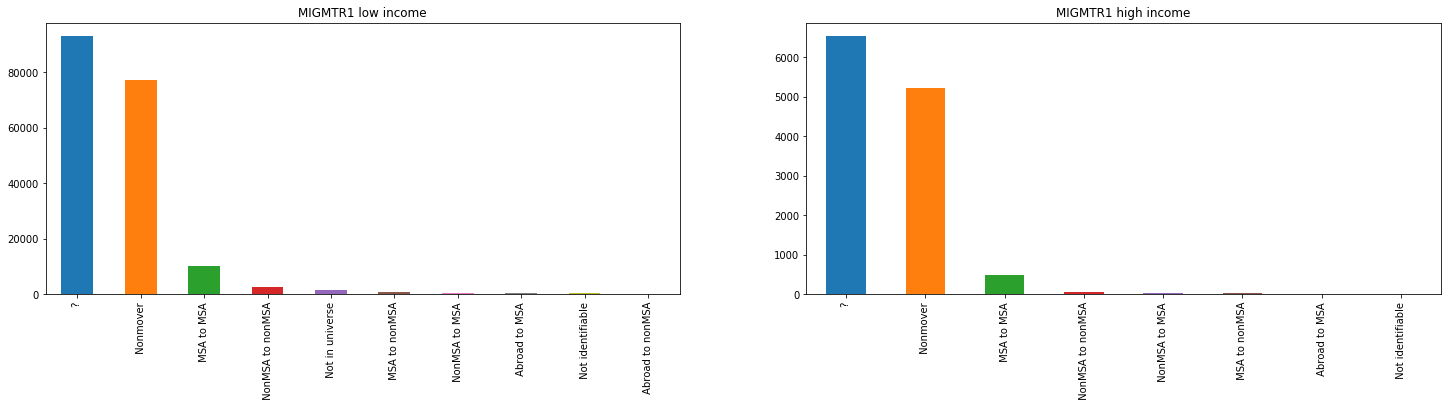

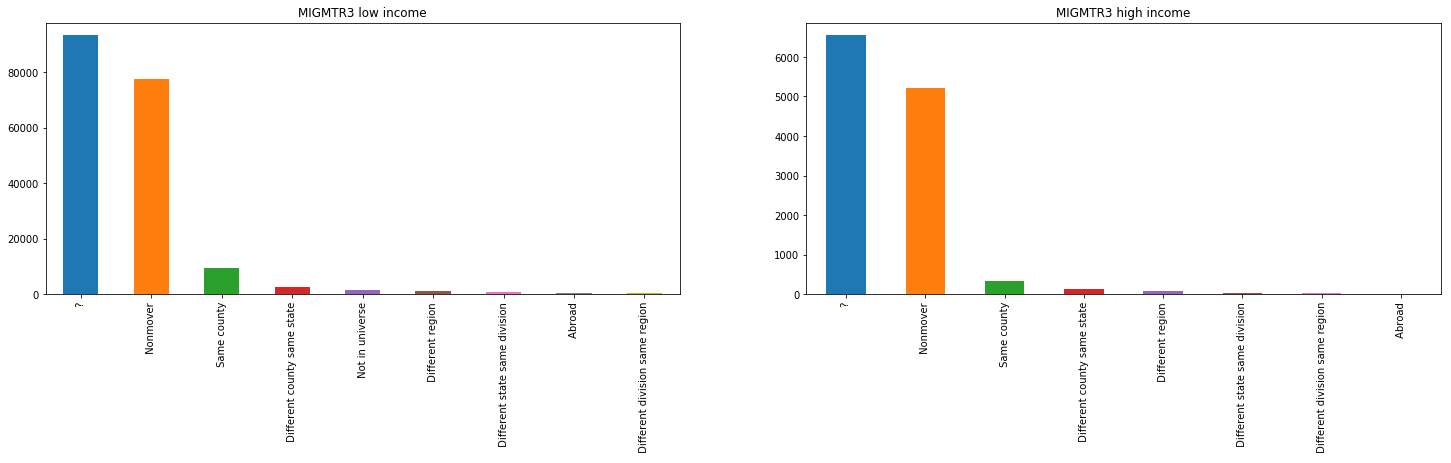

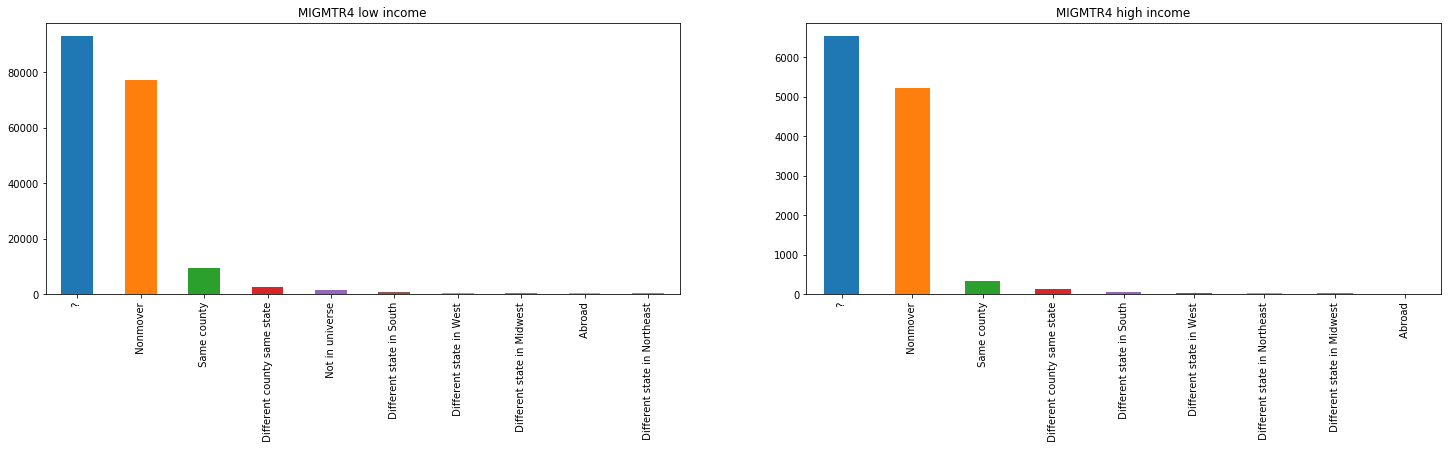

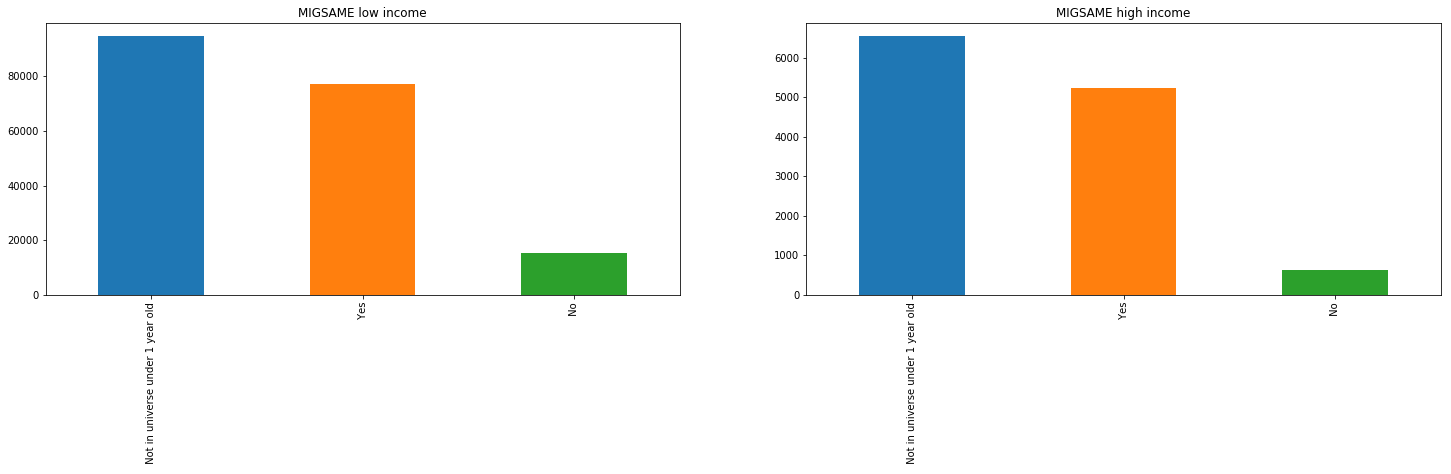

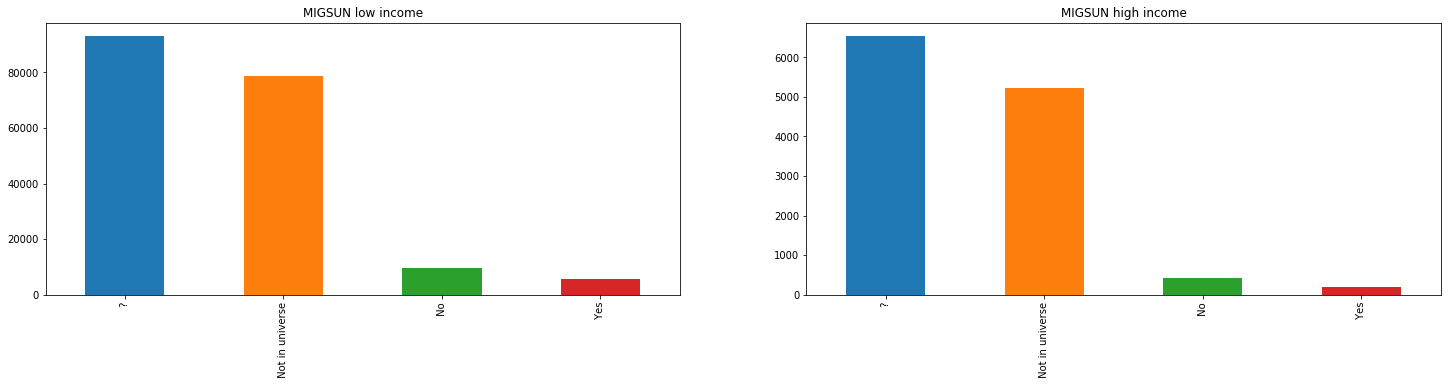

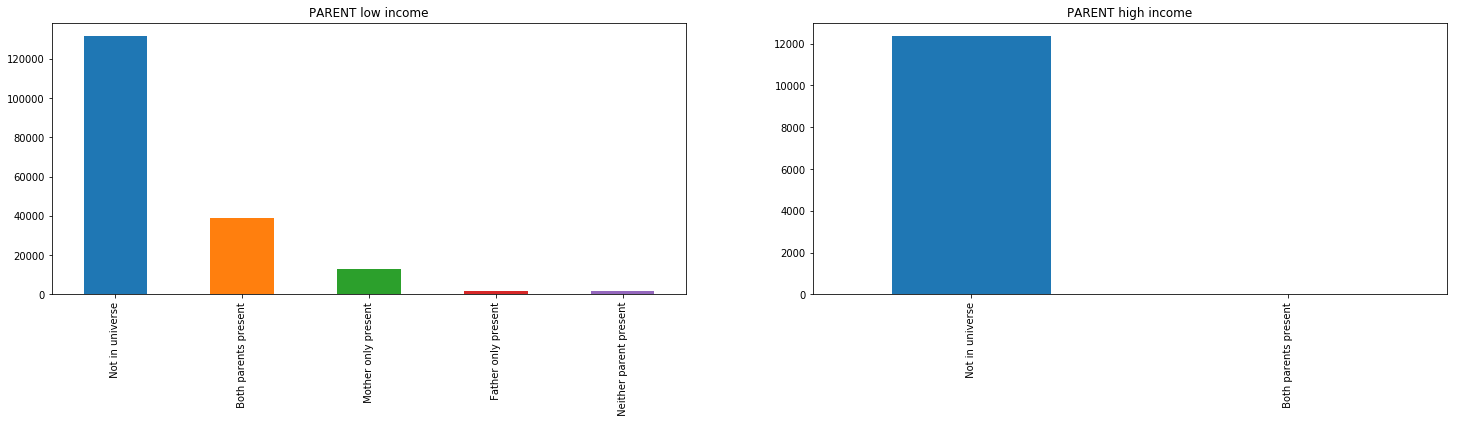

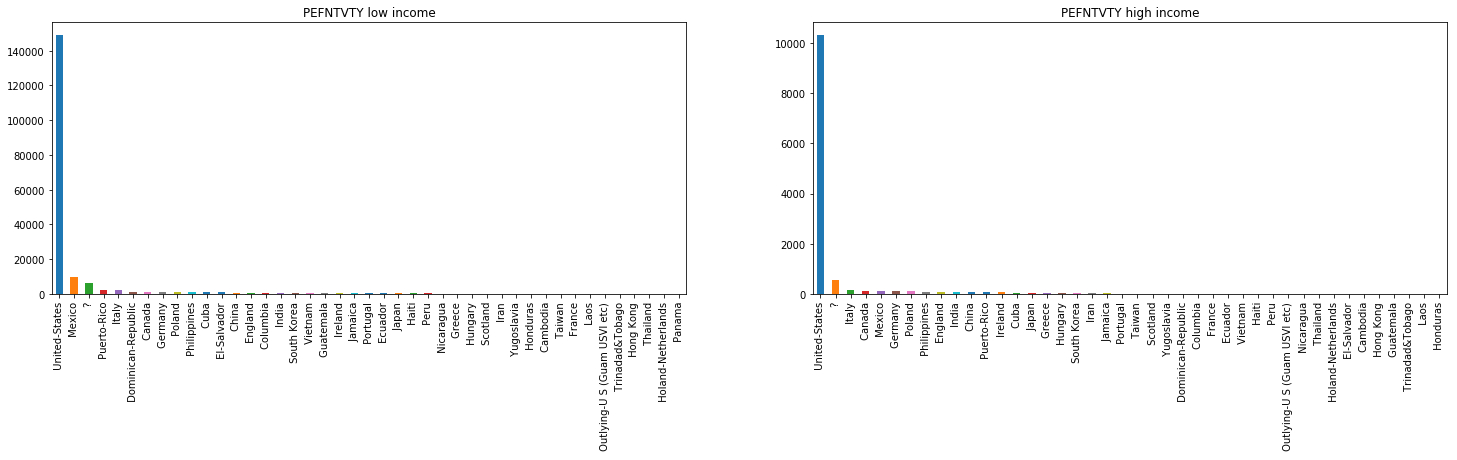

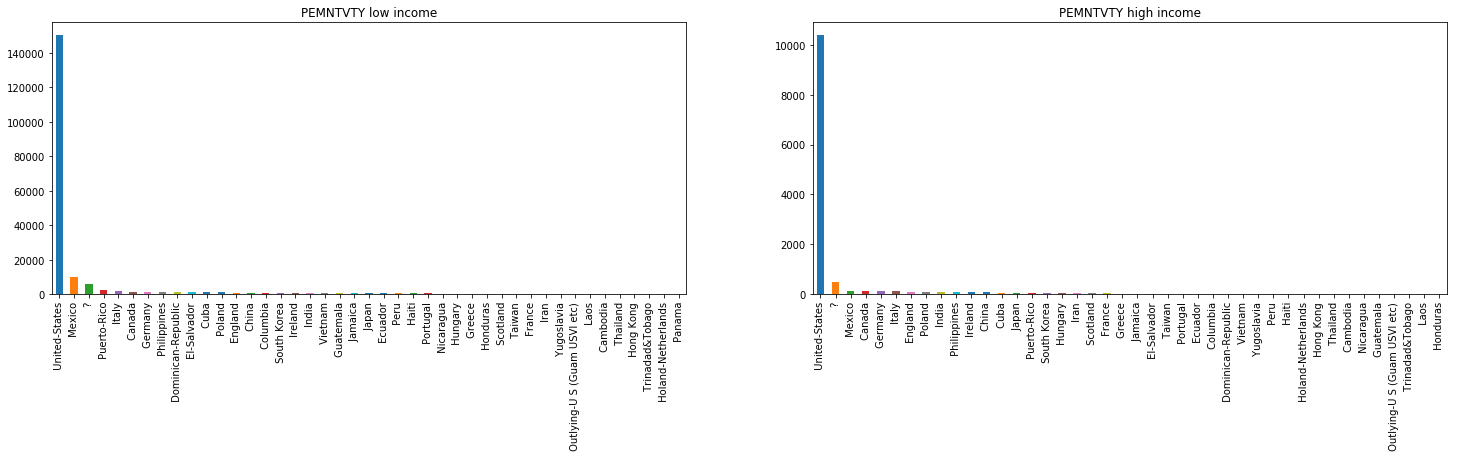

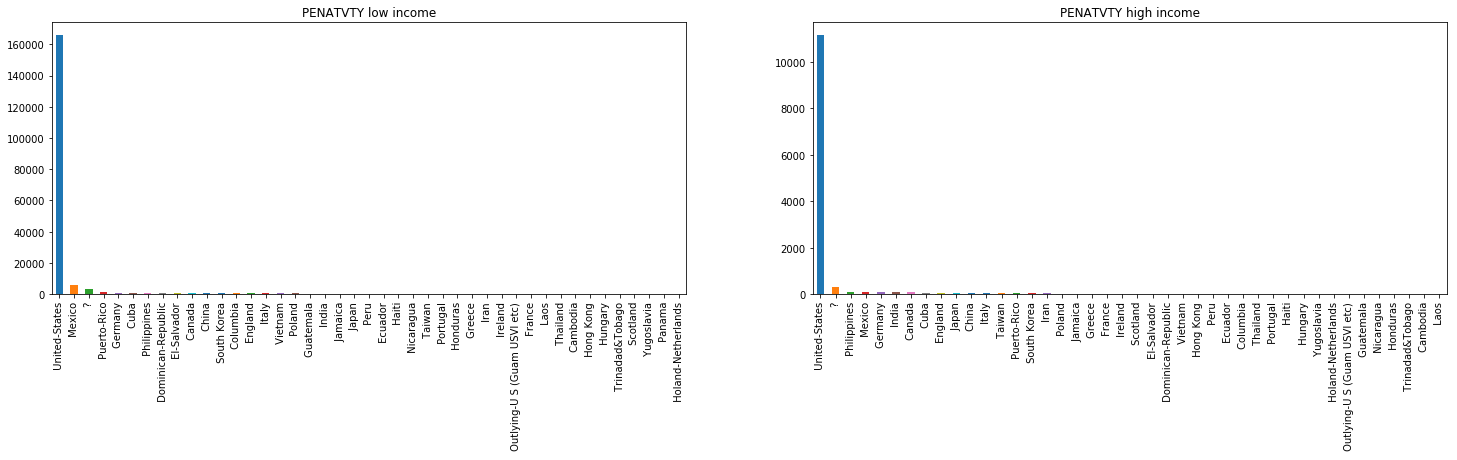

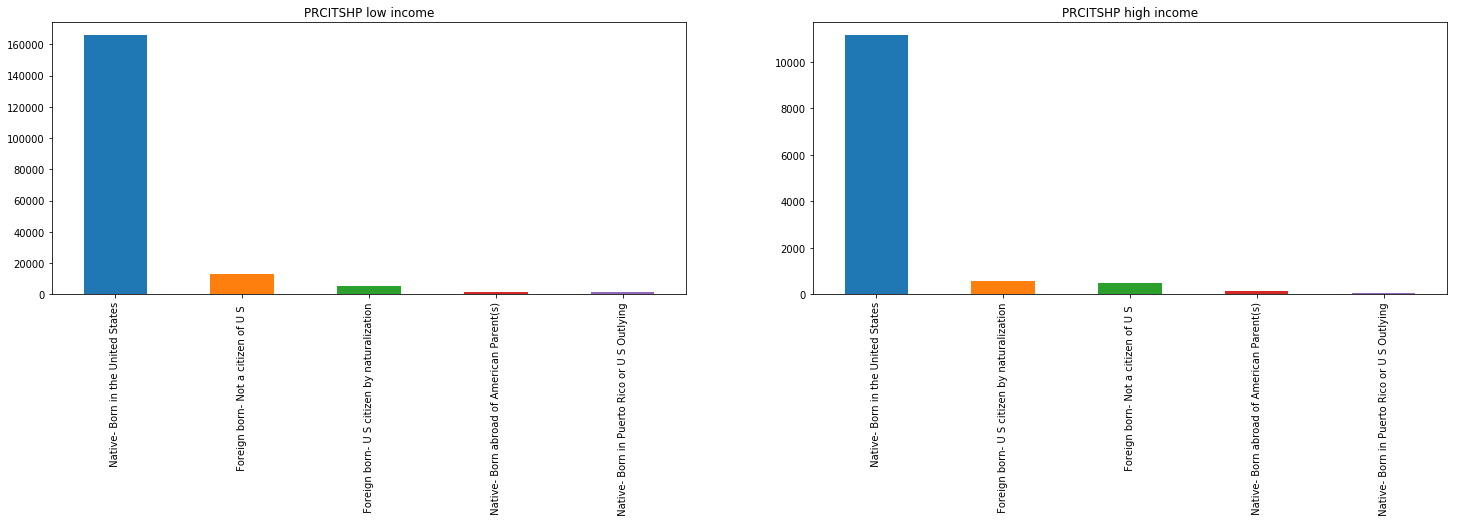

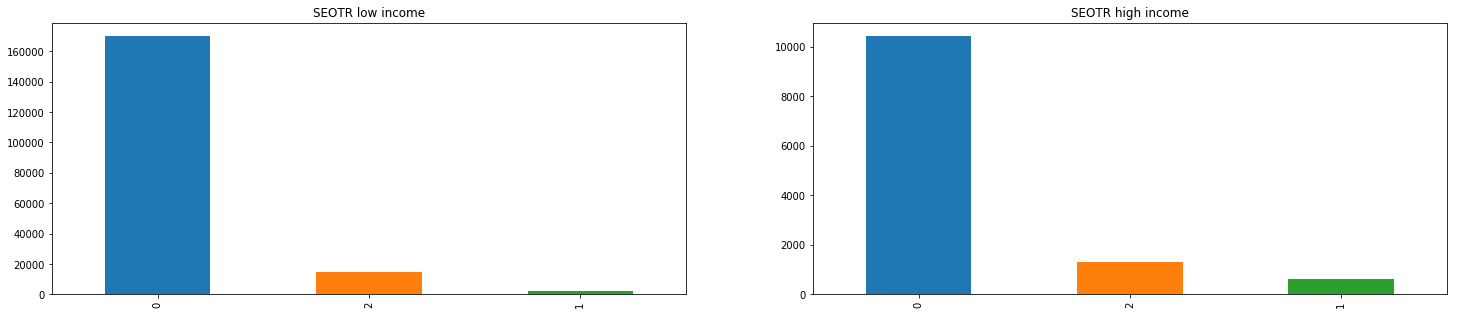

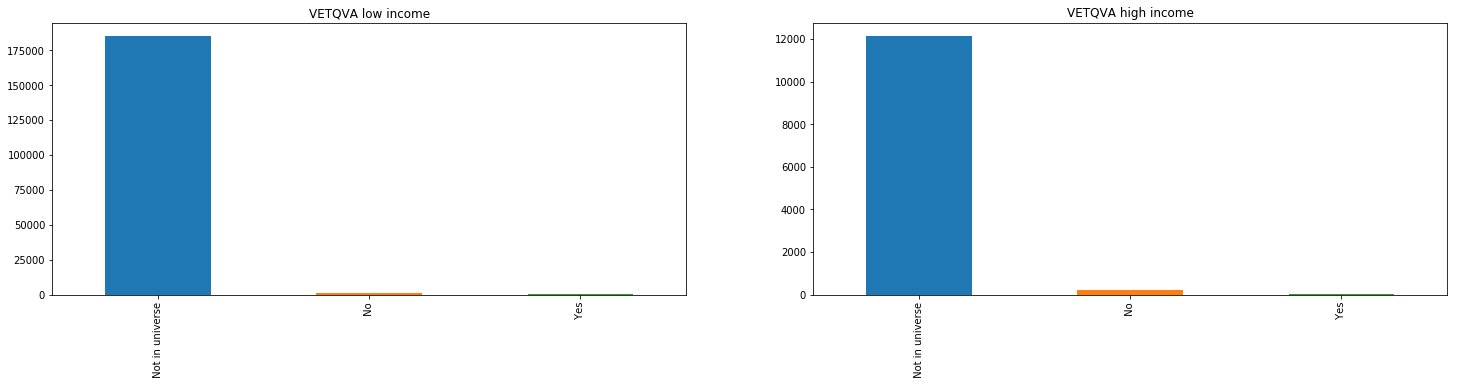

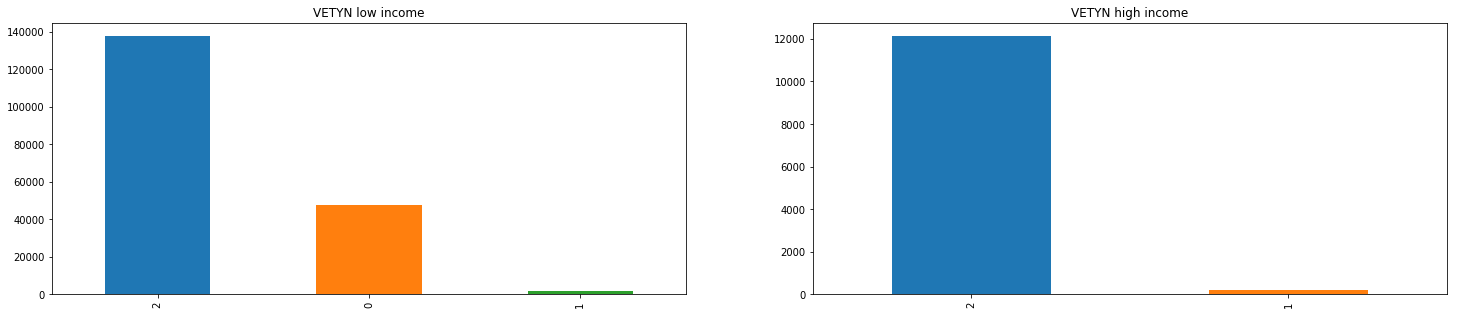

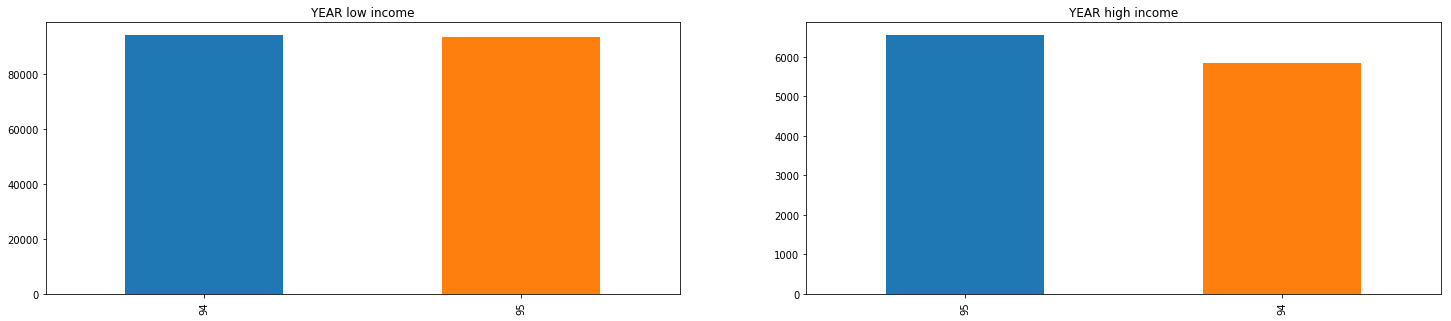

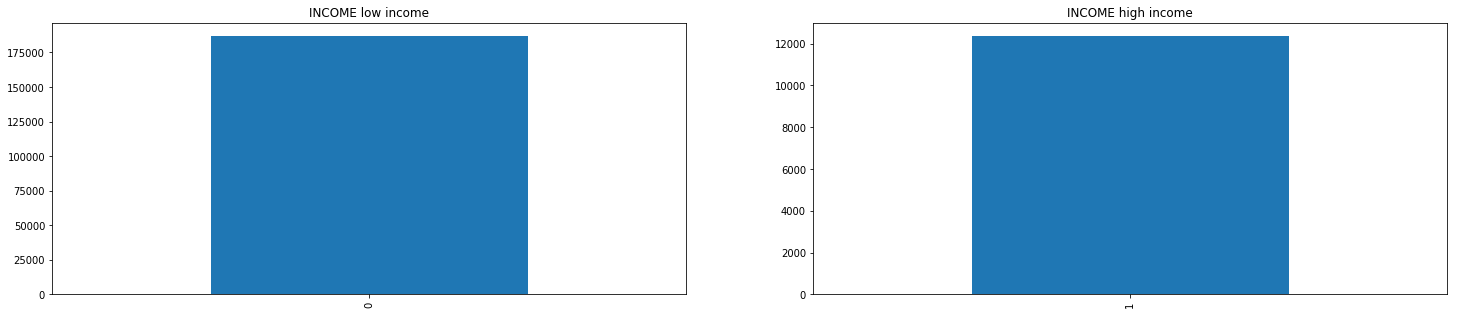

In [42]:
# Annexe all the plots of the data
for k in categorical:
    fig,axes=plt.subplots(nrows=1,ncols=2)
    df[k].loc[(df["INCOME"]==1) ].value_counts().plot(kind="bar",title=(k+' high income'),ax=axes[1],figsize=(25,5))
    df[k].loc[(df["INCOME"]==0) ].value_counts().plot(kind="bar",title=(k+' low income'),ax=axes[0],figsize=(25,5))
    plt.show()